In [1]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
#Read the data into a pandas data frame 
df = pd.read_parquet("de_train.parquet")

In [3]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie 
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [4]:
############################DATA PREP###############################



####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
inputs = np.hstack((hot_cells, hot_compounds))
inputs_df = pd.DataFrame(data = inputs)


####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)



In [5]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:151]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:151]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values)
trainOut_t = torch.tensor(trainOut_df.values)
valIn_t = torch.tensor(valIn_df.values)
valOut_t = torch.tensor(valOut_df.values)




In [6]:
#Build each layer of nueral network
#Provide forward method to train network
class Layer1(nn.Module):
    def __init__(self, input_size, hidden1_size, num_classes):
        #Initialzing layers
        super(Layer1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, num_classes)
        self.act_output = nn.Sigmoid()
    #training function
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.act_output(out)
        return out
    
#Instantiate class with input, hidden layer, and output size 
model1 = Layer1(152,1024,18211)
#Change to double data type
model1.double()

Layer1(
  (fc1): Linear(in_features=152, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=18211, bias=True)
  (act_output): Sigmoid()
)

In [7]:
#Build each layer of nueral network
#Provide forward method to train network
class Layer2(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        #Initialzing layers
        super(Layer2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        self.act_output = nn.Sigmoid()
    #training function
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.act_output(out)
        return out
    
#Instantiate class with input, hidden layer, and output size 
model2 = Layer2(152,1024,16384,18211)
#Change to double data type
model2.double()



Layer2(
  (fc1): Linear(in_features=152, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=16384, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16384, out_features=18211, bias=True)
  (act_output): Sigmoid()
)

In [8]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)

In [9]:
# compute accuracy (no_grad is optional)
def deviation():
    with torch.no_grad():
        y_pred = model1(valIn_t)

    accuracy = (abs((y_pred-valOut_t)).sum()/valOut_t.sum())
    RSS = ((y_pred-valOut_t)**2).float().sum()
    return (f"Deviation: {100*accuracy}%    RSS: {RSS}")



In [10]:
#training loop 
def train(epoch_number, batch_size):
    epoch_losses = []
    epoch_deviation = []
    
    for epoch in range(epoch_number):
        batch_losses = []
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size]
            ybatch = trainOut_t[i:i+batch_size]
            
            y_pred = model1(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After each epoch, get the mean loss and deviation.
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        
        dev = deviation()
        epoch_deviation.append(dev)
        
        print(f"Epoch {epoch}, Loss: {epoch_loss}, {dev}")
    
    return epoch_losses, epoch_deviation



Epoch 0, Loss: 0.5996961980590665, Deviation: 16.982475013739087%    RSS: 14744.5087890625
Epoch 1, Loss: 0.5272467264082542, Deviation: 11.478601544322759%    RSS: 10537.2724609375
Epoch 2, Loss: 0.5233376649736513, Deviation: 10.388484737191419%    RSS: 9702.5634765625
Epoch 3, Loss: 0.5223553792484134, Deviation: 10.389193915852019%    RSS: 9468.814453125
Epoch 4, Loss: 0.5218288071005093, Deviation: 10.411743934186344%    RSS: 9347.029296875
Epoch 5, Loss: 0.5214322489320786, Deviation: 10.431715039760551%    RSS: 9275.2236328125
Epoch 6, Loss: 0.5210989199264949, Deviation: 10.452896647668801%    RSS: 9225.8359375
Epoch 7, Loss: 0.5207936892413766, Deviation: 10.468196450841575%    RSS: 9185.1708984375
Epoch 8, Loss: 0.5205006980949206, Deviation: 10.487178783886307%    RSS: 9148.234375
Epoch 9, Loss: 0.5202052616276748, Deviation: 10.50402183961508%    RSS: 9110.9638671875


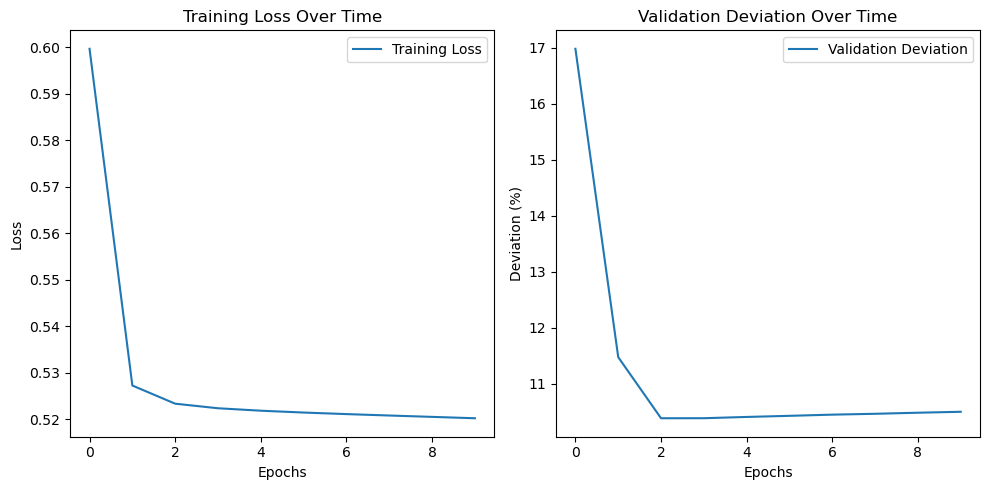

In [11]:

# Call your train function
losses, deviations = train(10, 20)

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Since deviations is a list of strings, you'll need to convert it to float values
deviation_values = [float(dev.split('%')[0].split(': ')[1]) for dev in deviations]

# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot(deviation_values, label='Validation Deviation')
plt.xlabel('Epochs')
plt.ylabel('Deviation (%)')
plt.title('Validation Deviation Over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# compute accuracy on training set 
def deviationtrain():
    with torch.no_grad():
        y_pred = model1(trainIn_t)

    accuracy = (abs((y_pred-trainOut_t)).sum()/trainOut_t.sum())
    RSS = ((y_pred-trainOut_t)**2).float().sum()
    return (f"Deviation: {100*accuracy}%    RSS: {RSS}")

deviationtrain()

'Deviation: 8.229646555430483%    RSS: 26338.72265625'

In [13]:
def hot_encode(cell,compound):
    cell_vec = np.zeros(cell_mapping.size)
    cell_dict = {value: index for index, value in enumerate(cell_mapping)}

    compound_vec = np.zeros(compound_mapping.size)
    compound_dict = {value: index for index, value in enumerate(compound_mapping)}


    cell_vec[cell_dict[cell]]=1
    compound_vec[compound_dict[compound]]=1
    vector = np.concatenate((cell_vec, compound_vec), axis = 0)
    tensor = torch.from_numpy(vector)
    return tensor


In [14]:
model1(hot_encode("NK cells", "Clotrimazole"))

tensor([0.1425, 0.2461, 0.4919,  ..., 0.4428, 0.4528, 0.5499],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [19]:
def get_expression(cell_type, compound_name):
    tensor = model1(hot_encode(cell_type,compound_name))
    np_array = tensor.detach().numpy()
    df = pd.DataFrame(np_array)
    return unnormalize(df[0],norm_min,norm_max)


df = get_expression("NK cells", "Clotrimazole")
print(df)




0        0.352196
1        0.481949
2       -0.950288
3       -0.373793
4        0.814279
           ...   
18206    0.312108
18207    0.039815
18208    0.209169
18209   -0.390617
18210   -0.224997
Length: 18211, dtype: float64


In [21]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize an empty list to collect the predicted values
predicted_values = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']
    
    # Call your get_expression method here
    expression_values = get_expression(cell_type, sm_name)
    
    # Append the values to the list
    predicted_values.append(expression_values)

# Convert the list of predicted values to a numpy array
predicted_values_array = np.array(predicted_values)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_array

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)

